In [1]:
!pip install numpy
!pip install gym==0.7
!pip install pyglet==1.5.27
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.6/936.6 kB 11.6 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.7.0-py3-none-any.whl size=201576 sha256=e71496f9a012794c592b37b5391d69a147142938dc716b58e10f775ca084b8e3
  Stored in directory: /root/.cache/pip/wheels/45/41/63/c8ad08982323c2d78191ea49280294935111fd8e5010534f85
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00
  Attempting uninstall: pyglet
    Found existing installation: pyglet 2.0.17
    Uninstalling pyglet-2.0.17:
      Successfully uninstalled pyglet-2.0.17


In [2]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt

# 0. Simple Policy Function
Write a function that computes the policy with a weight of a matrix.

- Prototype: ```def policy(matrix, weight):```


In [3]:
def policy(matrix, weight):
    """ computes action probabilities for a given state using a linear
        transformation.

    Args:
        matrix (np.ndarray): The input state represented as a matrix.
        weight (np.ndarray): The weight matrix that defines the policy.

    Returns:
        np.ndarray: A probability distribution over actions for the given
            state.
    """
    # apply linear transformation to get raw scores
    raw_scores = np.dot(matrix, weight)
    # apply exponential and shift scores to prevent overflow
    stabilized_scores = np.exp(raw_scores - np.max(raw_scores))
    # convert raw exponentiated scores into probabilities
    action_probs = stabilized_scores / np.sum(stabilized_scores)
    return action_probs

## 0-main.py

In [4]:
import numpy as np

weight = np.ndarray((4, 2), buffer=np.array([
    [4.17022005e-01, 7.20324493e-01],
    [1.14374817e-04, 3.02332573e-01],
    [1.46755891e-01, 9.23385948e-02],
    [1.86260211e-01, 3.45560727e-01]
    ]))
state = np.ndarray((1, 4), buffer=np.array([
    [-0.04428214,  0.01636746,  0.01196594, -0.03095031]
    ]))

res = policy(state, weight)
print(res)

[[0.50351642 0.49648358]]


# 1.Compute the Monte-Carlo policy gradient
By using the previous function created ```policy```, write a function that computes the Monte-Carlo policy gradient based on a state and a weight matrix.

- Prototype: ```def policy_gradient(state, weight):```
  - ```state:``` matrix representing the current observation of the environment
  - ```weight:``` matrix of random weight
- Return: the action and the gradient (in this order)

In [5]:
def softmax_grad(softmax):
    """ computes the gradient of the softmax function.

    Args:
        softmax (np.ndarray): The softmax output probabilities.

    Returns:
        np.ndarray: The gradient of the softmax output.
    """

    # reshape softmax probs to prepare for matrix operations
    softmax = softmax.reshape(-1, 1)
    # calculate the softmax gradient by subtracting the outer product from the
    # diagonal matrix
    softmax_grad = np.diagflat(softmax) - np.dot(softmax, softmax.T)
    return softmax_grad


def policy_gradient(state, weight):
    """ computes the action and the gradient of the policy for a given
        state.

    Args:
        state (np.ndarray): current state of the environment.
        weight (np.ndarray): weight matrix for the policy.

    Returns:
        tuple: A tuple containing:
            - action (int): selected action based on the policy.
            - grad (np.ndarray): gradient of the policy for the given state.
    """

    # get action probabilities for the current state using updated policy
    action_probs = policy(state, weight)

    # get next action using action probabilities
    action = np.random.choice(len(action_probs[0]), p=action_probs[0])

    # get gradient of softmax probabilities at the choosen action, which
    # indicates how the action probabilities change
    softmax_g = softmax_grad(action_probs)[action, :]

    # caclulate the log probabilities of the choosen actions based on
    # the softmax gradient,  normalizing the gradient of softmax
    # function relative to the pobability of the choosen action
    log_probs = softmax_g / action_probs[0, action]

    # get the gradient of the policy which will be used to update
    # the policies weights, and add extra dimension to the log probabilities
    grad = state.T.dot(np.expand_dims(log_probs, axis=0))

    return action, grad

## 1-main.py

In [6]:
env = gym.make('CartPole-v1')
np.random.seed(1)

weight = np.random.rand(4, 2)
state = env.reset()[None,:]
print(weight)
print(state)

action, grad = policy_gradient(state, weight)
print(action)
print(grad)

env.close()

INFO:gym.envs.registration:Making new env: CartPole-v1
[2024-09-23 15:52:31,741] Making new env: CartPole-v1


[[4.17022005e-01 7.20324493e-01]
 [1.14374817e-04 3.02332573e-01]
 [1.46755891e-01 9.23385948e-02]
 [1.86260211e-01 3.45560727e-01]]
[[-0.04727975 -0.00835178  0.03939286  0.02549332]]
0
[[-0.02346321  0.02346321]
 [-0.00414468  0.00414468]
 [ 0.01954924 -0.01954924]
 [ 0.0126514  -0.0126514 ]]


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:18: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# 2. Implement the training
By using the previous function created ```policy_gradient```, write a function that implements a full training.

- Prototype: ```def train(env, nb_episodes, alpha=0.000045, gamma=0.98):```
  - ```env```: initial environment
  - ```nb_episodes```: number of episodes used for training
  - ```alpha```: the learning rate
  - ```gamma```: the discount factor
- Return: all values of the score (sum of all rewards during one episode loop)
Since the training is quite long, please print the current episode number and the score after each loop. To display these information on the same line, you can use ```end="\r", flush=False``` of the print function.


In [7]:
def update_grad(rewards, grads, alpha, gamma, policy_weights):
    """ updates the policy weights based on the rewards and gradients
        collected during an episode.

    Args:
        rewards (np.ndarray): rewards received for each action taken.
        grads (list): list of gradients corresponding to each action taken.
        alpha (float): learning rate for updating the weights.
        gamma (float): discount factor for future rewards.
        policy_weights (np.ndarray): current weights of the policy.

    Returns:
        np.ndarray: updated policy weights.
    """
    # over each timesteps gradient
    for i in range(len(grads)):
        # find the discounted sum of rewards
        discounted_sum = np.sum(rewards[i:] * (gamma ** rewards[i:]))
        # update the policy weights proportioanl to the rewards and learning
        # rate
        policy_weights += alpha * discounted_sum * grads[i]
    return policy_weights


def train(env, nb_episodes, alpha=0.000045, gamma=0.98):
    """ trains the policy gradient agent by running multiple episodes
        in the given environment and optionally renders the environment
        to visualize the agent's performance.

    Args:
        env (gym.Env): OpenAI Gym environment to train the agent in.
        nb_episodes (int): number of episodes to run for training.
        alpha (float): learning rate for updating the policy weights.
        gamma (float): discount factor for future rewards.
        show_result (bool): if True, renders the environment every 1000
            episodes.

    Returns:
        list: list of scores for each episode.
    """
    # initialize policy weights using the action and observation space
    num_actions = env.action_space.n
    num_states = env.observation_space.shape[0]
    policy_weights = np.random.rand(num_states, num_actions)

    # keep track of scores for each episode
    scores = []

    # for each episode
    for episode in range(nb_episodes + 1):

        # reset environment to get initial state
        # add extra dimention to the state
        state = np.expand_dims(env.reset(), axis=0)

        # keep track of rewards and gradients for the episode
        rewards = []
        grads = []

        # keep track of score during this episode
        score = 0

        # max score for cartpole v1 is 500, so each episode can run for 500
        # steps maximum
        for _ in range(500):

            # get new action and the policy gradient for the update
            action, grad = policy_gradient(state, policy_weights)

            # get new state and reward
            new_state, reward, done, _ = env.step(action)

            # add new dimension to new state and add reward to the score
            state = np.expand_dims(new_state, axis=0)
            score += reward

            # keep track of the rewards and gradients for each episode
            rewards.append(reward)
            grads.append(grad)

            # if game is terminated, break
            if done:
                break

        # print the episode and score for every episode, occasionally pausing
        # to better view score
        print(
            'Episode: {} Score: {}'.format(
                episode,
                score),
            end="\r",
            flush=False)
        if episode % 100 == 0:
            time.sleep(.5)

        # keep track of each total score for an episode
        scores.append(score)
        # update the policy weights
        policy_weights = update_grad(
            np.array(rewards), grads, alpha, gamma, policy_weights)

    return scores

## 2-main.py

INFO:gym.envs.registration:Making new env: CartPole-v1
[2024-09-23 15:52:31,780] Making new env: CartPole-v1


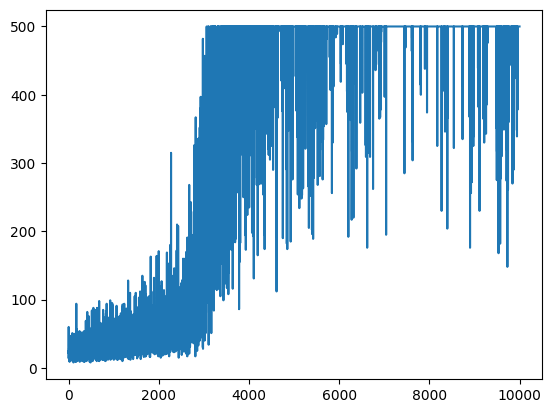

In [8]:

env = gym.make('CartPole-v1')

scores = train(env, 10000)

plt.plot(np.arange(len(scores)), scores)
plt.show()
env.close()

# 3. Animate iteration
Update the prototype of the ```train``` function by adding a last optional parameter ```show_result``` (default: ```False```).

When this parameter is ```True```, render the environment every 1000 episodes computed.

In [30]:
def update_grad(rewards, grads, alpha, gamma, policy_weights):
    """ updates the policy weights based on the rewards and gradients
        collected during an episode.

    Args:
        rewards (np.ndarray): rewards received for each action taken.
        grads (list): list of gradients corresponding to each action taken.
        alpha (float): learning rate for updating the weights.
        gamma (float): discount factor for future rewards.
        policy_weights (np.ndarray): current weights of the policy.

    Returns:
        np.ndarray: updated policy weights.
    """
    # over each timesteps gradient
    for i in range(len(grads)):
        # find the discounted sum of rewards
        discounted_sum = np.sum(rewards[i:] * (gamma ** rewards[i:]))
        # update the policy weights proportioanl to the rewards and learning
        # rate
        policy_weights += alpha * discounted_sum * grads[i]
    return policy_weights


def train(env, nb_episodes, alpha=0.000045, gamma=0.98, show_result=False):
    """ trains the policy gradient agent by running multiple episodes
        in the given environment and optionally renders the environment
        to visualize the agent's performance.

    Args:
        env (gym.Env): OpenAI Gym environment to train the agent in.
        nb_episodes (int): number of episodes to run for training.
        alpha (float): learning rate for updating the policy weights.
        gamma (float): discount factor for future rewards.
        show_result (bool): if True, renders the environment every 1000
            episodes.

    Returns:
        list: list of scores for each episode.
    """
    # initialize policy weights using the action and observation space
    num_actions = env.action_space.n
    num_states = env.observation_space.shape[0]
    policy_weights = np.random.rand(num_states, num_actions)

    # keep track of scores for each episode
    scores = []

    # for each episode
    for episode in range(nb_episodes + 1):

        # reset environment to get initial state
        # add extra dimention to the state
        state = np.expand_dims(env.reset(), axis=0)

        # keep track of rewards and gradients for the episode
        rewards = []
        grads = []

        # keep track of score during this episode
        score = 0

        # max score for cartpole v1 is 500, so each episode can run for 500
        # steps maximum
        for _ in range(500):

            # get new action and the policy gradient for the update
            action, grad = policy_gradient(state, policy_weights)

            # get new state and reward
            new_state, reward, done, _ = env.step(action)

            # render cartpole every 1000 episodes
            if (episode - 1) % 1000 == 0 and show_result:
                env.render(mode='human')

            # add new dimension to new state and add reward to the score
            state = np.expand_dims(new_state, axis=0)
            score += reward

            # keep track of the rewards and gradients for each episode
            rewards.append(reward)
            grads.append(grad)

            # if game is terminated, break
            if done:
                break

        # print the episode and score for every episode, occasionally pausing
        # to better view score
        print(
            'Episode: {} Score: {}'.format(
                episode,
                score),
            end="\r",
            flush=False)
        if episode % 100 == 0:
            time.sleep(.5)

        # keep track of each total score for an episode
        scores.append(score)
        # update the policy weights
        policy_weights = update_grad(
            np.array(rewards), grads, alpha, gamma, policy_weights)

    return scores


## 3-main.py
* note: this one will not run in colab

In [32]:
env = gym.make('CartPole-v1')

scores = train(env, 10000, 0.000045, 0.98, True)

env.close()

INFO:gym.envs.registration:Making new env: CartPole-v1
[2024-09-23 16:15:29,456] Making new env: CartPole-v1
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:18: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


GLException: No GL context; create a Window first